# Scikit learn Tree

In [39]:
import os
import sys
import re
import random
import math
import scipy
import numpy as np
import pandas as pd
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.cm as cm

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold # import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

from mpl_toolkits.mplot3d import Axes3D
cmapRdYlGn = cm.get_cmap('RdYlGn')
cmap = cm.coolwarm

challenge_data_folder = "./challenge_data"

#outlier detection http://scikit-learn.org/stable/modules/outlier_detection.html

In [2]:
pdAllData = pd.read_csv(challenge_data_folder+"/train.csv",keep_default_na=False) #Load training data NA filter FALSE to keep Not available data
columnTypesDict = pdAllData.dtypes.to_dict() #Infer part of the data schema
columnNames = list(columnTypesDict.keys()) #List of all features name

In [3]:
lb_make = LabelEncoder()

for featureCol in pdAllData:
    if pdAllData[featureCol].dtype=='object':
        pdAllData[featureCol] = lb_make.fit_transform(pdAllData[featureCol])
    else:
        continue
#pdAllData.head()
X = pdAllData.drop(['Id','SalePrice'],axis=1)
Y = pdAllData.SalePrice

kept_columnValues = list(X.columns.values)
X_scaled_array = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array,columns=kept_columnValues)

In [67]:
def getLogRMSE(estimatedPrice,realPrice):
    logRMSE = np.mean( (np.log(estimatedPrice) - np.log(realPrice))**2 )
    return np.sqrt(logRMSE)
def regressionTrees(X=X,X_outliers=[],Y_outliers=[],Y=Y,depth=6,min_samples_leaf=8,test_size=0.1,singleTree=True,forest=False,extraTrees=False,nb_estimator=20):
    #X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = test_size, random_state = 42)# np.random.randint(0,100))
    nkfold = int(1/test_size)
    kf = KFold(n_splits=nkfold)
    test_errors = []
    training_errors = []
    X= np.array(X)
    Y=np.array(Y)
    X_outliers = np.array(X_outliers)
    for train_index, test_index in kf.split(X):
        X_outliers_test = X_outliers[kf.split(X_outliers)[foldNb][1]] #get a proportinal number of outliers to calculate error
        Y_outliers_test = Y_outliers[kf.split(X_outliers)[foldNb][1]]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        if singleTree: regressor = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf,max_depth=depth)
        elif forest: regressor = RandomForestRegressor(min_samples_leaf=min_samples_leaf,max_depth=depth,n_estimators=nb_estimator,random_state=42)#, max_depth=depth,min_samples_leaf=min_samples_leaf)
        elif extraTrees: regressor = ExtraTreesClassifier(min_samples_leaf=min_samples_leaf,max_depth=depth,n_estimators=nb_estimator,random_state=42)#, max_depth=depth,min_samples_leaf=min_samples_leaf)

        regressor.fit(X_train, y_train)
        y_hat_test = regressor.predict(X_test)
        training_estimation = regressor.predict(X_train)
        y_hat_test_outliers = regressor.predict(X_outliers_test)
        
        y_hat_test = np.concatenate((y_hat_test,y_hat_test_outliers))
        y_test = np.concatenate((y_train,Y_outliers_test))
        
        test_errors.append(getLogRMSE(y_hat_test,y_test))
        training_errors.append(getLogRMSE(training_estimation,y_train))
    return np.mean(test_errors),np.mean(training_errors),regressor #test error train error

### Launch until this

In [91]:
clf = DecisionTreeRegressor()
clf = clf.fit(X_scaled, Y)
feature_importances_forest = clf.feature_importances_
sort_index_forest = np.argsort(feature_importances)

clf = RandomForestRegressor()
clf = clf.fit(X_scaled, Y)
feature_importances = clf.feature_importances_
sort_index = np.argsort(feature_importances)

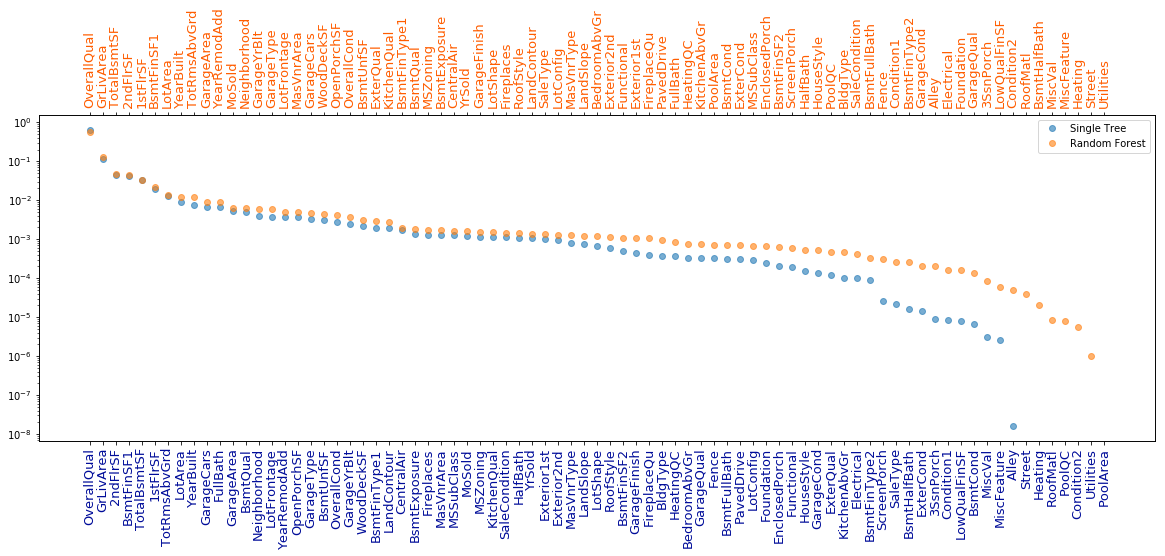

In [139]:
fig, ax =plt.subplots(figsize=(20,6))
ax.semilogy(np.sort(feature_importances_forest)[::-1],'o',label='Single Tree',alpha=0.6)
locs = ax.set_xticks(np.arange(79))
ax.set_xticklabels(np.array(kept_columnValues)[sort_index_forest][::-1], rotation='vertical',fontsize=13)
[x.set_color('#000c99') for x in ax.get_xticklabels()]

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(79))


ax.semilogy(np.sort(feature_importances)[::-1],'o',label='Random Forest',alpha=0.6)
ax2.set_xticks(np.arange(79))
ax2.set_xticklabels(np.array(kept_columnValues)[sort_index][::-1], rotation='vertical',fontsize=13)
[x.set_color('#ff5d00') for x in ax2.get_xticklabels()]


pylab.ylabel("Feature Importance")
ax.legend()
plt.show()

In [105]:
sort_index_forest_desc = sort_index_forest[::-1]
test_errors = []
train_errors = []
#Study test error in respect to nb of feature selected
range_selection = range(1,len(sort_index_forest_desc))
for i in range_selection:
    selected_features = np.array(kept_columnValues)[sort_index_forest_desc[:i]]
    X_scaled_trimmed = X_scaled[selected_features]
    test_error,train_error,regressor = regressionTrees(X=X_scaled_trimmed,Y=Y,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)
    train_errors.append(train_error)
    test_errors.append(test_error)

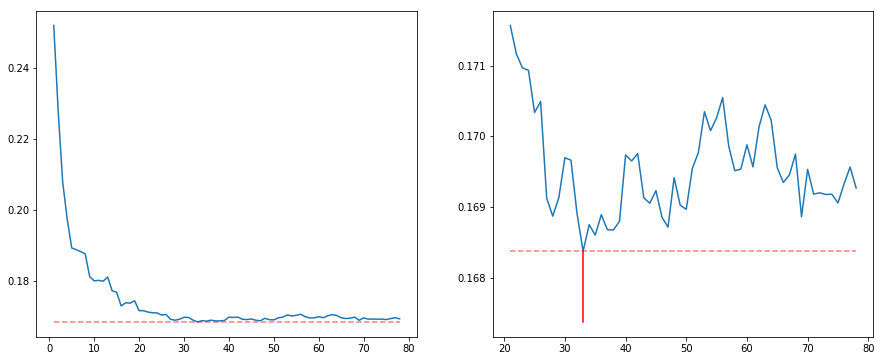

In [111]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(range_selection,test_errors)
plt.plot(range_selection,[np.min(test_errors)]*len(range_selection),'r--',alpha=0.5)


plt.subplot(122)
min_slice = 20
max_slice = 79
argmin = np.argmin(test_errors)
plt.plot(range_selection[min_slice:max_slice],test_errors[min_slice:max_slice])
plt.plot(range_selection[min_slice:max_slice],[np.min(test_errors)]*len(range_selection[min_slice:max_slice]),'r--',alpha=0.5)
argmin = np.argmin(test_errors)
plt.plot([argmin+1,argmin+1],[np.min(test_errors)-0.001,np.min(test_errors)],'r')
plt.show()

In [120]:
selected_features = np.array(kept_columnValues)[sort_index_forest_desc[:np.argmin(test_errors)+1]]
X_scaled_trimmed = X_scaled[selected_features]
test_error,train_error,regressor = regressionTrees(X=X_scaled_trimmed,Y=Y,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)

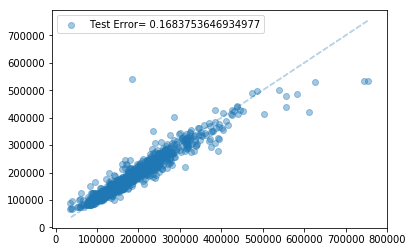

In [126]:
plt.plot(Y,Y,'--',alpha=0.3,label="")
plt.scatter(Y,regressor.predict(X_scaled_trimmed),alpha=0.4,label="Test Error= "+str(test_error))
plt.legend()
plt.show()

## PCA

In [136]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X_scaled_trimmed)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
finalDf = pd.concat([principalDf, Y], axis = 1)
finalDf.head()

,pc1,pc2,SalePrice
0,1.351947,0.493472,208500
1,0.620304,-2.703257,181500
2,1.672887,0.288789,223500
3,-0.953848,0.773230,140000
4,4.297102,0.457182,250000


In [132]:
testerror,trainerror,regressor = regressionTrees(X=principalDf,Y=Y,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)

In [66]:
np.concatenate((regressor.predict(X),regressor.predict(X))).shape

(2400,)

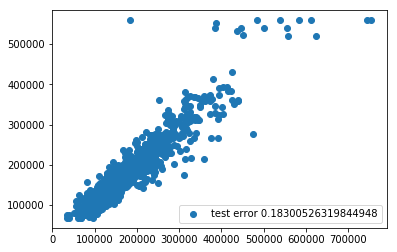

In [133]:
plt.scatter(Y,regressor.predict(principalDf),label='test error '+str(testerror))
plt.legend()
plt.show()

In [134]:
testErrors = []
for i in range(2,80):
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(X_scaled_array)
    principalDf = pd.DataFrame(data = principalComponents)
    testerror,trainerror,regressor = regressionTrees(X=principalDf,Y=Y,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)
    testErrors.append(testerror)

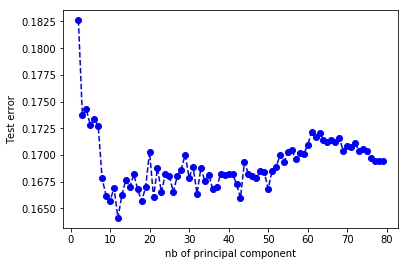

In [135]:
plt.plot(range(2,80),testErrors,'b--o')
plt.xlabel('nb of principal component')
plt.ylabel("Test error")
plt.show()

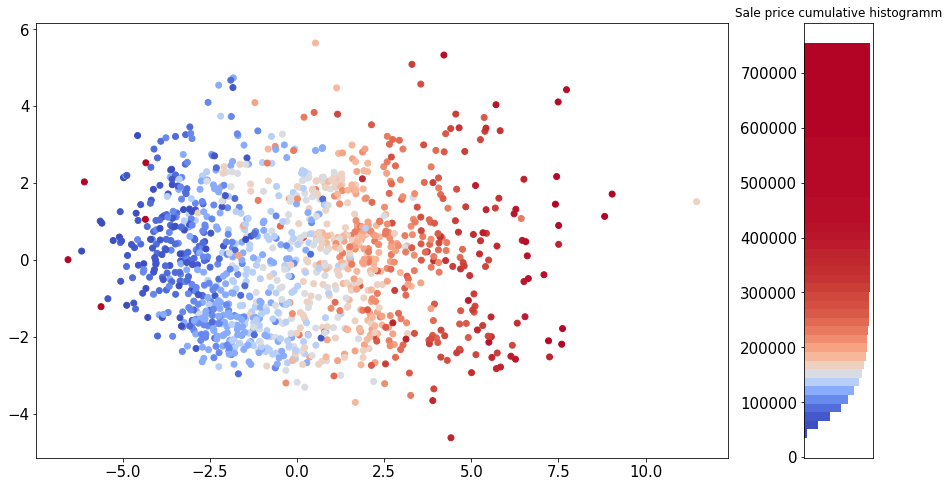

In [137]:
plt.figure(figsize=(15,8))
hist = plt.hist(finalDf.SalePrice,cumulative=True,normed=True,bins='auto')
for c, p in zip(hist[0], hist[2]):
    plt.setp(p, 'facecolor', cmap(c))
plt.clf()
plt.close()
def normHist(row):
    salePrice = row.SalePrice
    index = [i for i,x in enumerate(hist[1]) if x<=salePrice][-1]
    #print(index,salePrice)
    return hist[0][index-1]
colors = finalDf.apply(normHist,axis=1)


plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(1, 2, width_ratios=[10, 1])
plt.subplot(gs[0])
sc = plt.scatter(finalDf.pc1,finalDf.pc2,c=colors,cmap=cmap)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.colorbar(sc,ticks=finalDf.SalePrice)
plt.subplot(gs[1])
histbis = plt.hist(finalDf.SalePrice,cumulative=True,normed=True,bins='auto',orientation='horizontal')
for c, p in zip(histbis[0], histbis[2]):
    plt.setp(p, 'facecolor', cmap(c))
plt.gca().set_xscale("log")
plt.title("Sale price cumulative histogramm")
plt.yticks(fontsize=15)
plt.tick_params(axis='x',which='both',bottom='off',labelbottom='off')
plt.show()

### Consider outliers

Automatically created module for IPython interactive environment


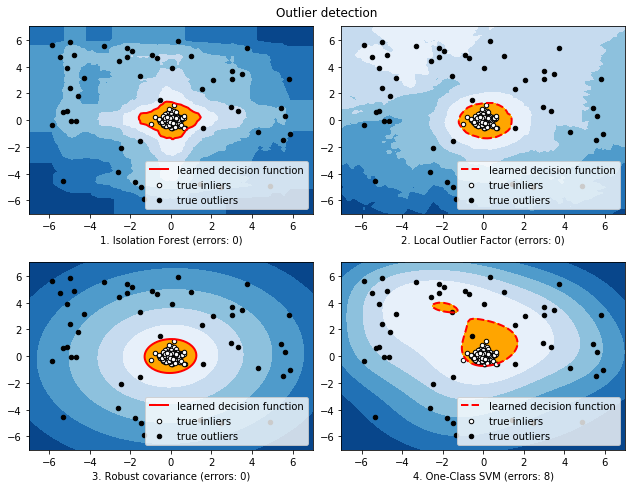

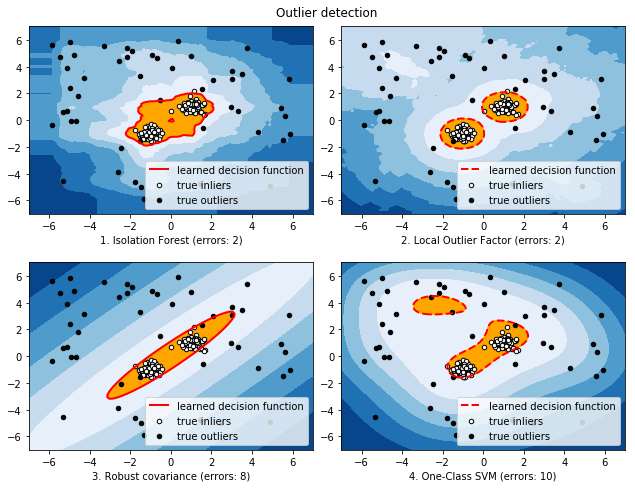

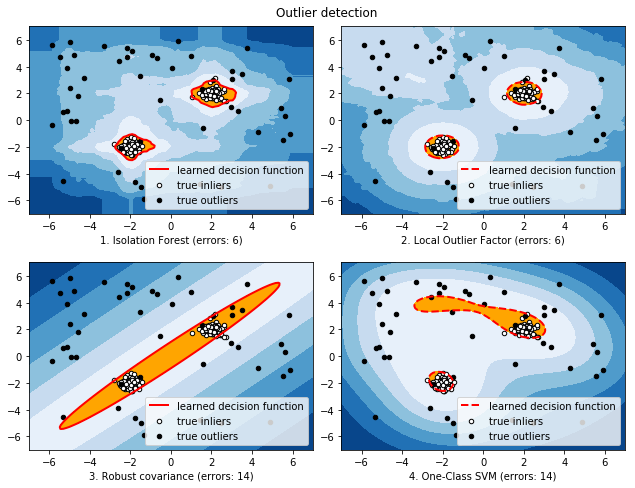

In [143]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

rng = np.random.RandomState(42)

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples,
                                        contamination=outliers_fraction,
                                        random_state=rng),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=35,
        contamination=outliers_fraction)}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(9, 7))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        if clf_name == "Local Outlier Factor":
            y_pred = clf.fit_predict(X)
            scores_pred = clf.negative_outlier_factor_
        else:
            
            
            
            clf.fit(X)
            scores_pred = clf.decision_function(X)
            y_pred = clf.predict(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        
        
        n_errors = (y_pred != ground_truth).sum()
        
        
        
        
        # plot the levels lines and the points
        if clf_name == "Local Outlier Factor":
            # decision_function is private for LOF
            Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(2, 2, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")

plt.show()

### Isolation forest

In [31]:
from sklearn.ensemble import IsolationForest
from scipy import stats

outliers_fraction = 0.05

def findOutliers_IsolationForest(X, outliers_fraction):
    clf = IsolationForest(max_samples=len(X), contamination=outliers_fraction, random_state=42)
    clf.fit(X)
    scores_pred = clf.decision_function(X)
    y_pred = clf.predict(X)
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    return scores_pred, y_pred, threshold

scores_pred, y_pred, threshold = findOutliers_IsolationForest(X, outliers_fraction)

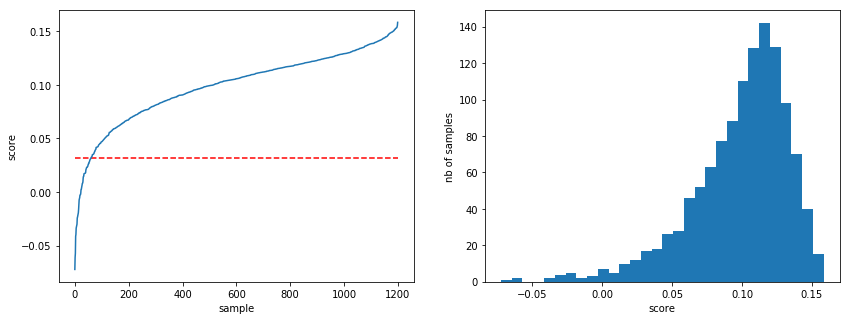

In [21]:
plt.figure(figsize=(14,5))
plt.subplot(121)
scores_pred_sorted = np.sort(scores_pred)
plt.plot([0,1199],[threshold]*2,'--',c='red')
plt.plot(scores_pred_sorted),plt.xlabel("sample"),plt.ylabel("score")
plt.subplot(122)
plt.hist(scores_pred_sorted, bins='auto'),plt.xlabel("score"),plt.ylabel("nb of samples")
plt.show()

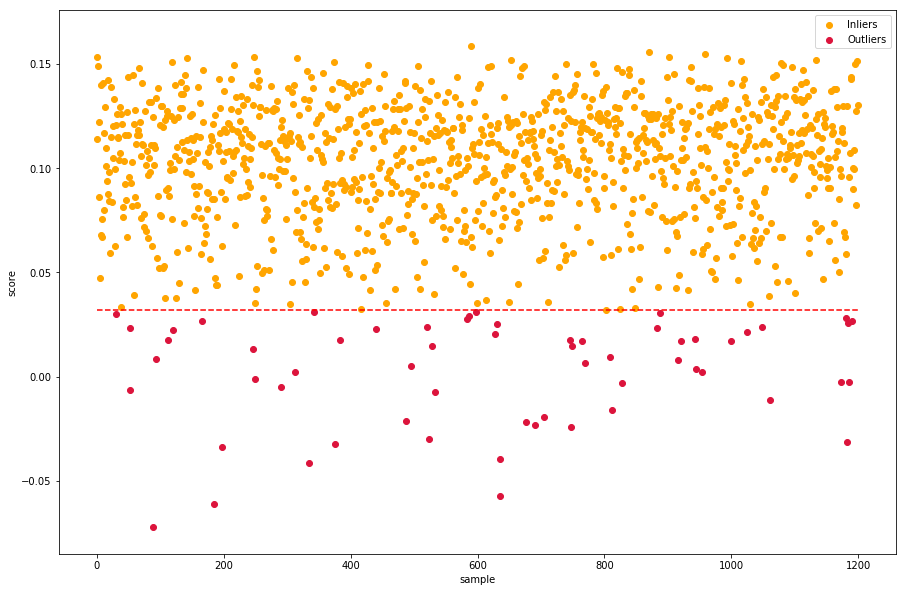

In [22]:
inlier = np.array([[i,scores_pred[i]] for i,x in enumerate(y_pred) if x==1])
outlier = np.array([[i,scores_pred[i]] for i,x in enumerate(y_pred) if x==-1])

plt.figure(figsize=(15,10))
plt.scatter(inlier.T[0],inlier.T[1],c="orange",label="Inliers")
plt.scatter(outlier.T[0],outlier.T[1],c="crimson",label="Outliers")
plt.plot([0,1199],[threshold]*2,'--',c='red')

plt.xlabel("sample")
plt.ylabel("score")
plt.legend()
plt.show()

In [72]:
outlier_index = np.where(y_pred==-1)[0]
X_WO = X.drop(outlier_index)
Y_WO = Y.drop(outlier_index)
X_outliers = X.filter(outlier_index,axis=0)
Y_outliers = Y.filter(outlier_index,axis=0)
print(X_WO.shape,Y_WO.shape)
print(X_outliers.shape,Y_outliers.shape)
len(outlier_index)

(60, 79) (60,)
(1140, 79) (1140,)


1140

In [73]:
X_scaled_array_WO = StandardScaler().fit_transform(X_WO)
X_scaled_WO = pd.DataFrame(X_scaled_array_WO,columns=kept_columnValues)
testerror,trainerror,regressor = regressionTrees(X=X_scaled_WO,Y=Y_WO,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)

TypeError: 'generator' object is not subscriptable

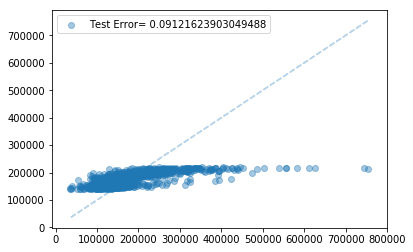

In [62]:
plt.plot(Y,Y,'--',alpha=0.3,label="")
plt.scatter(Y,regressor.predict(X_scaled),alpha=0.4,label="Test Error= "+str(testerror))
plt.legend()
plt.show()

In [60]:
testErrors = []
trainErrors = []

outliers_fractions = np.arange(0.00,1,0.05)

for outliers_fraction in outliers_fractions:
    scores_pred, y_pred, threshold = findOutliers_IsolationForest(X, outliers_fraction)
    outlier_index = np.where(y_pred==-1)[0]
    X_WO = X.drop(outlier_index)
    Y_WO = Y.drop(outlier_index)
    X_scaled_array_WO = StandardScaler().fit_transform(X_WO)
    X_scaled_WO = pd.DataFrame(X_scaled_array_WO,columns=kept_columnValues)
    testerror, trainerror, regressor = regressionTrees(X=X_scaled_WO,Y=Y_WO,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)
    
    testErrors.append(testerror)
    trainErrors.append(trainerror)


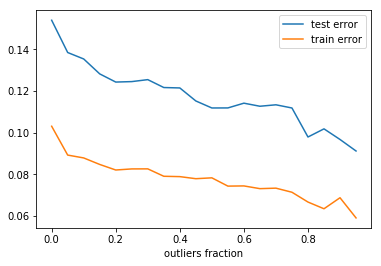

In [61]:
plt.plot(outliers_fractions,testErrors, '-',label="test error")
plt.plot(outliers_fractions,trainErrors, label="train error")
plt.xlabel("outliers fraction")
plt.legend()
plt.show()

### SOM

In [22]:
!pip install minisom

  Running setup.py bdist_wheel for minisom ... done
  Stored in directory: /root/.cache/pip/wheels/bf/41/74/f249faec59290949ed0f67953dadb616efc3e6860c9dcba454
Successfully built minisom
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


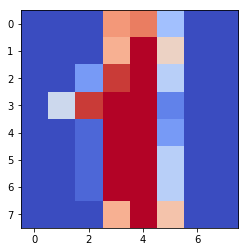

In [42]:
num[1]
plt.imshow(digits.images[1],cmap=cmap)

Training...

...ready!


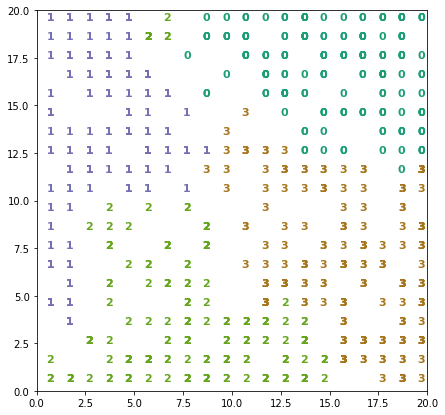

In [26]:
from minisom import MiniSom

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from  sklearn import datasets

# load the digits dataset from scikit-learn
# 901 samples,  about 180 samples per class
# the digits represented 0, 1, 2, 3, 4

digits = datasets.load_digits(n_class=4)
data = digits.data  # matrix where each row is a vector that represent a digit.
num = digits.target  # num[i] is the digit represented by data[i]

som = MiniSom(20, 20, 64, sigma=.8, learning_rate=0.5)
print("Training...")
som.train_random(data, 1500)  # random training
print("\n...ready!")
plt.figure(figsize=(7, 7))
wmap = {}
im = 0
for x, t in zip(data, num):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5,  str(t),
              color=plt.cm.Dark2(t / 4.), fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.show()